In [24]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [25]:
!pip install transformers
!pip install -U -q PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pandas as pd
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig
from torch.utils.data import TensorDataset, random_split
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format(sentences):
  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case=False)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [27]:
import pandas as pd

data = pd.read_csv("/content/NLP Ethos - Hindi - ethos.csv")
data = data.sample(frac = 1).reset_index(drop=True)
total = data.shape[0]
train_data = data.iloc[:801, 2:]
train_data = train_data.sample(frac = 1).reset_index(drop=True)
validation_data = data.iloc[801:, 2:]
validation_data = validation_data.sample(frac = 1).reset_index(drop=True)
train_data.head()

,Label,Translation
0,1,लकवाग्रस्त बच्चों को पत्थर फेंकना मेरा पसंदीदा...
1,1,कुरान में साफ लिखा है जो कुरान को नहीं मानता व...
2,0,यह फकहैड मुझे यहूदी होने पर शर्मिंदा करता है। ...
3,1,मुझे वास्तव में आपका लहजा पसंद नहीं है। मैं आप...
4,0,"ओह, मुझे लगता है कि 13 reasons why आत्महत्या क..."


In [28]:
type(data)

pandas.core.frame.DataFrame

In [29]:
validation_data.head()

,Label,Translation
0,0,इस्लाम सच्चा धर्म है। इस पर विश्वास करें भाइयों।
1,1,यदि आप समलैंगिक हैं तो मेरे पास आपके लिए एक प्...
2,1,गंदी चीनी
3,1,पुरुष जाति स्त्रियों की अधीनस्थ है
4,1,उन कमीनों को लात मारो और कभी वापस मत आना। इस्ल...


In [30]:
print('Shape of training data is:', train_data.shape)
print('Shape of validation data (eng) is:', validation_data.shape)
#print('Shape of validation data (hindi) is:', validation_data_hindi.shape)

train_len = train_data.shape[0]
val_len = validation_data.shape[0]
#val_len_hindi = validation_data_hindi.shape[0]

Shape of training data is: (801, 2)
Shape of validation data (eng) is: (221, 2)


<Axes: xlabel='Label', ylabel='count'>

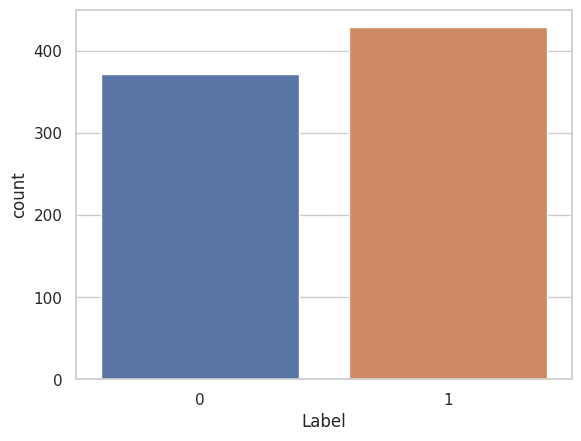

In [31]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=train_data['Label'])

<Axes: xlabel='Label', ylabel='count'>

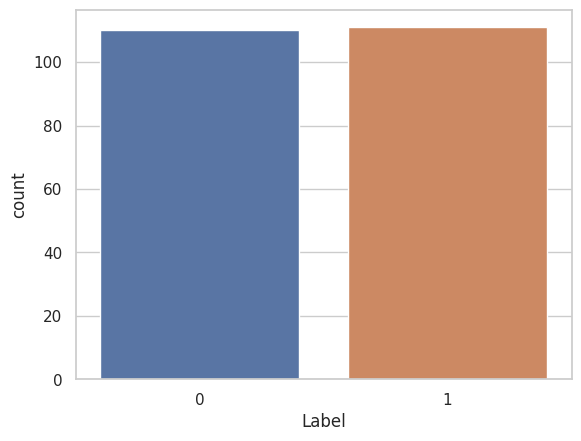

In [32]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data['Label'])

In [33]:
text = data.Translation.values
labels = data.Label.values

### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(text)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', text[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  नहीं ट्रम्प! हम चाहते हैं कि आप सभी अवैध अप्रवासियों को निर्वासित करें! जब मैं कहता हूं सब, मेरा मतलब है सब! अवधि! मैं»¿
Token IDs: tensor([   101,  16791,    875,  53606,  20429,  18187,    106, 105127,    870,
         66921,  17203,  11716,  14117,    852,  18187,  35387,    851,  15070,
         18438,  27694,    851,  18187,  18321, 102116,  19966,  11267,    884,
         46354,  27155,  34646,  13184,  16192,  42057,    106,  29404,    889,
         99007,    865, 108775,  11208,    899,  15778,  14018, 110334,    117,
         40265,  31277,    889,  11845,  11714,  18351,  10569, 110334,    106,
           851,  15070,  32831,    106,    889,  99007,    220,    224,    102,
             0])


In [34]:
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:, 2:]

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801)]
val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801, total)]


train_text = [text[i] for i in range(801)]
val_text = [text[i] for i in range(801, total)]

In [35]:
data = pd.read_csv("/content/Friends Hatespeech Multilingual Dataset - Sheet1.csv")
test_data = data.iloc[:, 1:3]
test_data = test_data.sample(frac = 1).reset_index(drop=True)
test_data.head()

,label,Translations
0,1,"तो तुम बस ऐसे ही, एक आदमी हो जो नैनी है?"
1,0,मुझें नहीं पता! मैं नहीं—शायद आप थोड़ा नाराज म...
2,1,तुम एक मूर्ख हो!
3,0,"हाँ, वे करते हैं! बच्चे की तरह बनना छोड़ो और म..."
4,0,"ओहायो में एक गर्भवती महिला है, और उसने हमें चु..."


In [36]:
test_text = test_data.Translations.values
test_labels = test_data.label.values
test_len = test_data.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids, test_attention_masks = tokenize_and_format(test_text)

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text[0])
print('Token IDs:', test_input_ids[0])

test_set = [(test_input_ids[i], test_attention_masks[i], test_labels[i]) for i in range(test_len)]

Original:  तो तुम बस ऐसे ही, एक आदमी हो जो नैनी है? 
Token IDs: tensor([  101, 21042,   880, 14070, 13841,   887, 13432, 70648, 14080,   117,
        11186,   852, 15552, 40340, 13220, 15134, 59029, 19810, 10569,   136,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
from transformers import BertForSequenceClassification, AdamW, XLMRobertaConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the base XLM-Roberta model
    num_labels = 2, # The number of output labels
    output_attentions = False, # Whether the model returns attention weights
    output_hidden_states = False, # Whether the model returns all hidden states
)

'''from transformers.adapters import PfeifferInvConfig

config = PfeifferInvConfig()
model.add_adapter("lang_adapter", config=config)
model.set_active_adapters("lang_adapter")'''

# from transformers.adapters import LoRAConfig

# config = LoRAConfig(r=8, alpha=16)
# model.add_adapter("lora_adapter", config=config)
# model.set_active_adapters("lora_adapter")

# Tell PyTorch to run this model on the GPU
model.cuda()


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [47]:
batch_size = 50
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-6, momentum=0.9, nesterov=True)
epochs = 10

In [48]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set, val_len):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    batch_size = 50

    num_batches = int(val_len/batch_size) + 1

    total_correct = 0
    mismatch_ids = []

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(val_set))
      #print(end_index)
      #print(i*batch_size)

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        
        batch_mismatch_ids = [index for index, elem in enumerate(labels_flat) if elem!=pred_flat[index]]
        batch_mismatch_ids = [index + i*batch_size for index in batch_mismatch_ids]
        # print(batch_mismatch_ids)
        mismatch_ids += batch_mismatch_ids

        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    return mismatch_ids, avg_val_accuracy

In [49]:
import random
# Set max_split_size_mb to 200 MB
#torch.cuda.set_per_process_memory_fraction(1, device=None)

# training loop

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    #print(train_len)
    # For each batch of training data...
    num_batches = int(train_len/batch_size) + 1
    #print(batch_size)
    #print(num_batches)

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      #print(len(batch))

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      #print(b_input_ids.shape)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                      token_type_ids=None,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    #_, val_acc_eng = get_validation_performance(val_set_eng, val_len_eng)
    #print(f"Validation accuracy English: {val_acc_eng}")
    _, val_acc_hindi = get_validation_performance(val_set, val_len)
    print(f"Validation accuracy Hindi: {val_acc_hindi}")
    
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
Total loss: 11.675607442855835
Validation accuracy Hindi: 0.583710407239819

======== Epoch 2 / 10 ========
Training...
Total loss: 11.1998450756073
Validation accuracy Hindi: 0.6334841628959276

======== Epoch 3 / 10 ========
Training...
Total loss: 10.024749651551247
Validation accuracy Hindi: 0.6832579185520362

======== Epoch 4 / 10 ========
Training...
Total loss: 8.546428374946117
Validation accuracy Hindi: 0.6877828054298643

======== Epoch 5 / 10 ========
Training...
Total loss: 6.51898392662406
Validation accuracy Hindi: 0.7420814479638009

======== Epoch 6 / 10 ========
Training...
Total loss: 4.363882964476943
Validation accuracy Hindi: 0.7692307692307693

======== Epoch 7 / 10 ========
Training...
Total loss: 2.547900923527777
Validation accuracy Hindi: 0.7104072398190046

======== Epoch 8 / 10 ========
Training...
Total loss: 2.8401631880551577
Validation accuracy Hindi: 0.7149321266968326

======== Epoch 9 / 10 ========
Training

In [50]:

mismatch_ids, test_acc = get_validation_performance(test_set, test_len)
print(test_acc)

0.568


In [51]:


incorrect_classif_instances = []
for i in range(len(mismatch_ids)):
  incorrect_classif_instances.append(test_text[i])

print(incorrect_classif_instances)

['तो तुम बस ऐसे ही, एक आदमी हो जो नैनी है? ', 'मुझें नहीं पता! मैं नहीं—शायद आप थोड़ा नाराज महसूस कर रहे हैं। शायद आह, शायद तुमने सोचा था कि तुम पहले शादी करोगे! शायद आप इस तथ्य को बर्दाश्त नहीं कर सकते कि आपके औपचारिक रूप से मोटे दोस्त की शादी आपसे पहले हो रही है!', 'तुम एक मूर्ख हो!', 'हाँ, वे करते हैं! बच्चे की तरह बनना छोड़ो और मुझे अकेला छोड़ो! देखो, तुमने अभी अपना पहला सबक सिख लिया है! ', 'ओहायो में एक गर्भवती महिला है, और उसने हमें चुना है!', 'मुझे अकेले वापस जाने का मन नहीं है, मुझे बहुत अकेलापन महसूस होता है। ओह, तुम मेरे साथ चलो?', 'हर कोई कहता है कि आपके पास पुरुष और महिला दोनों प्रजनन अंग हैं।', 'तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदमी बनो!', 'आप पर लज्जा होनी चाहिए! बदसूरत बच्चा आपका निर्णय करता है! ', 'चांडलर कितने साल का था जब उसने पहली बार किसी लड़की के स्तन को छुआ था?', 'बेवकूफ, बूढ़ी, नौकरी के लिए पूर्णतः उपयुक्त हिल्डा।', 'चांडलर! हर कोई--कोई भी मेरा टस्कन फिंगर फूड नहीं खा रहा है, क्योंकि वे सभी फीबे के बर्फीले शंकुओं को भर रहे हैं!', 'अरे, मुझे देखो, मैं एक